# Plot ROI Contours and color based on cluster grouping

What does this script do
------------------------------------
Takes in ROI masks, projection image, and clustering results to create a figure that visualizes ROI contours on the projection image. ROIs are colored based on which cluster they belong to


How to run this code
------------------------------------
Set user-defined variables


Input Requirements
------------------------------------
Requires the clustering results output from: event_related_clustering.ipynb 

Parameters
------------------------------------
__fdir__ : string 

    Root file directory containing the suite2p folder. IMPORTANT Note: leave off the last backslash, and include the letter r in front of string (treats the contents as a raw string). For example: r'C:\Users\my_user\analyze_sessions'

__preprocess_mode__ : string 

    Define the method that you used to preprocess the data. 's2p' for suite2p data (suite2p folder must be in fdir root folder) or 'sima' or 'napeca'

__proj_type__ : string 

    Select 'mean', 'std', or 'max' for type of projection image to plot contours on

In [1]:
import os
import numpy as np
import h5py
import pandas as pd
import pickle
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
# important for text to be detecting when importing saved figures into illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

import s2p_plot_rois_activity_funcs
import utils

In [2]:
# USER DEFINED VARIABLES
fdir = r'C:\Users\Public\Documents\2p_data\VJ_OFCVTA_7_D8_trained' # NOTE: the root folder name must match the basename of the _sima_masks.npy file

preprocess_mode = 's2p' # 's2p' or 'napeca'
proj_type = 'mean' # can be 'std', 'mean', 'max'
"""
define number of ROIs to visualize

can be: 
1) a list of select rois, 
2) an integer (n) indicating n first rois to plot, or 
3) None or 'all' which plots all valid ROIs
""" 
rois_to_plot = None # np.arange(5) #[0,2,3,6] 

In [3]:
# set paths
fname = os.path.split(fdir)[-1]
if 's2p' in preprocess_mode:
    path_dict = s2p_plot_rois_activity_funcs.s2p_dir(fdir)
    path_dict = s2p_plot_rois_activity_funcs.define_paths_roi_plots(path_dict, None, None, None)
else:
    proj_img_path = os.path.join(fdir, f'{fname}_output_images\{proj_type}_img.tif')
    roi_mask_path = os.path.join(fdir, f'{fname}_sima_masks.npy')
    sima_h5_path = os.path.join(fdir, f'{fname}_sima_mc.h5')

cluster_path = os.path.join(fdir, 'event_rel_analysis', 'cluster_labels.npy')

fig_save_dir = os.path.join(fdir, 'figs')
if not os.path.exists(fig_save_dir):
    os.mkdir(fig_save_dir)


In [4]:
# load projection image
proj_manual = {}
if 's2p' in preprocess_mode:
    s2p_data_dict = s2p_plot_rois_activity_funcs.load_s2p_data_roi_plots(path_dict)
    plot_vars = s2p_plot_rois_activity_funcs.prep_plotting_rois(s2p_data_dict, path_dict, True)
    proj_manual[f'{proj_type}_img'] = s2p_data_dict['ops']['meanImg']
elif os.path.exists(proj_img_path):
    proj_manual[f'{proj_type}_img'] = np.array(Image.open(proj_img_path))

elif os.path.exists(sima_h5_path):
    # load video data
    # open h5 to read, find data key, grab data, then close
    h5 = h5py.File(sima_h5_path,'r')
    sima_data = np.squeeze(np.array( h5[list(h5.keys())[0]] )).astype('int16') # np.array loads all data into memory
    h5.close()

    proj_manual = {'mean_img': np.mean(sima_data, axis = 0), 
                   'max_img': np.max(sima_data, axis = 0), 
                   'std_img': np.std(sima_data, axis = 0) }

In [5]:
# create/define ROI masks
if 's2p' in preprocess_mode:
    s2p_plot_rois_activity_funcs.masks_init(plot_vars, s2p_data_dict) # generates masks 
    roi_masks = plot_vars['s2p_masks']
else:
    # grab ROI masks from sima (these are probably manually drawn ROIs from imagej)
    fname_roi_masks = f'{fname}_sima_masks.npy'
    roi_masks = np.load(roi_mask_path)

if isinstance(rois_to_plot, int): # if int is supplied, first n user-curated rois included in analysis
    rois_to_plot = np.arange(rois_to_plot)
elif rois_to_plot in [None, 'all']: # if None is supplied, all user-curated rois included in analysis
    rois_to_plot = np.arange(roi_masks.shape[0])

num_rois = len(rois_to_plot)

In [6]:
# load cluster data
cluster_ids = np.load(cluster_path)
unique_cluster_ids = np.unique(cluster_ids)
num_clusters = len(unique_cluster_ids)

# define number of ROIs to visualize and make colormap for contours
colors_roi = plt.cm.viridis(np.linspace(0,1,num_clusters))

In [7]:
# make list of roi centroids for identifying where to plot each ROI's label on the projection/contour image
roi_label_loc_manual = []
for idx, iROI in enumerate(rois_to_plot):
    
    # make binary map of ROI pixels
    ypix_roi, xpix_roi = np.where(roi_masks[iROI,:,:] == 1)
    
    if ypix_roi.size == 0:
        roi_label_loc_manual.append( [0, 0] )
    else:
        roi_label_loc_manual.append( [np.min(ypix_roi), np.min(xpix_roi)] )


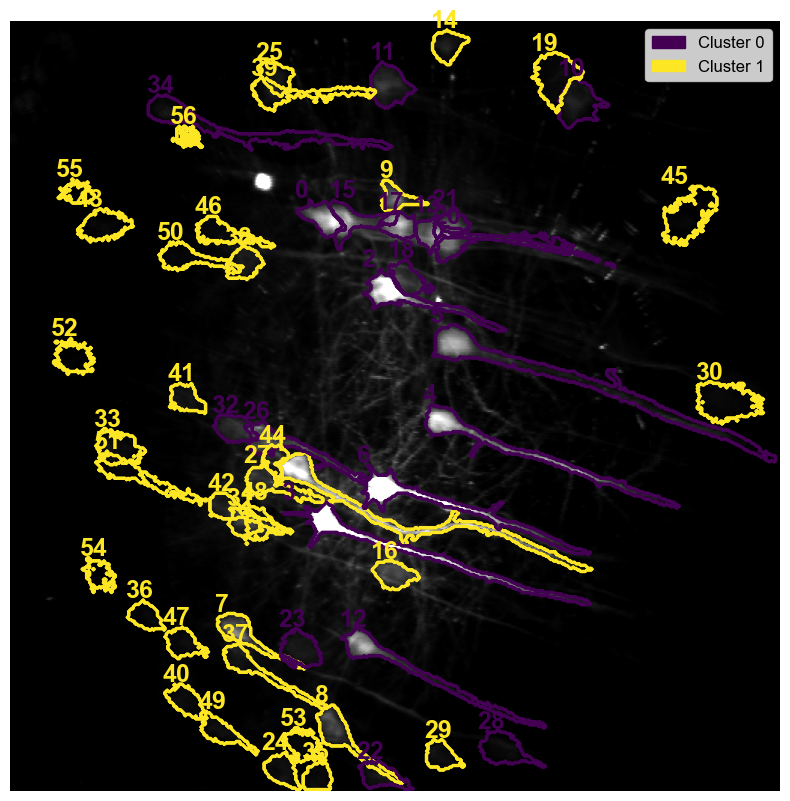

In [8]:
# plot contours and cell numbers on projection image
clims = [ np.min(proj_manual[f'{proj_type}_img'])*1.2, 
        np.max(proj_manual[f'{proj_type}_img'])*0.4 ] # change the hardcoded numbers to adjust color limits

fig, ax = plt.subplots(1, 1, figsize = (10,10))
im = ax.imshow(proj_manual[f'{proj_type}_img'], cmap = 'gray', vmin = clims[0]*1, vmax = clims[1]*0.8)
ax.axis('off')

for iROI, (roi_id, cluster_id) in enumerate(zip(rois_to_plot, cluster_ids)): 
    ax.contour(roi_masks[roi_id,:,:], colors=[colors_roi[cluster_id]])
    ax.text(roi_label_loc_manual[iROI][1]-2, roi_label_loc_manual[iROI][0]-2,  str(roi_id), fontsize=18, weight='bold', color = colors_roi[cluster_id])

plt.legend(handles=[mpatches.Patch(color=colors_roi[x], label=f'Cluster {str(x)}') for x in unique_cluster_ids], fontsize=12)
plt.show()